## 1. Import Required Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import sys
import os

sns.set_theme(style="whitegrid")
%matplotlib inline

try:
    sys.path.append(os.path.abspath(os.path.join('..', 'src')))
    from data_loader import FitFamDataLoader
    print("Module data_loader imported successfully.")
except ImportError:
    print("ERROR: The file data_loader.py is not found in the directory.")

loader = FitFamDataLoader()
unified_df = loader.get_unified_data()

print("Data loaded.")

Module data_loader imported successfully.
Data loaded.


## 2. Analysis by Year


--- Analysis for Year 2023 ---
Total lines : 48041
Total users : 3819
Period : from 2023-01-01 06:30:00 to 2023-12-31 10:50:00


C:\Users\gaspa\AppData\Local\Temp\ipykernel_2472\1260364760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_df['date'] = yearly_df['start_time']


Analyzable users (>90 days seniority) : 3341
New regularity metrics calculated.


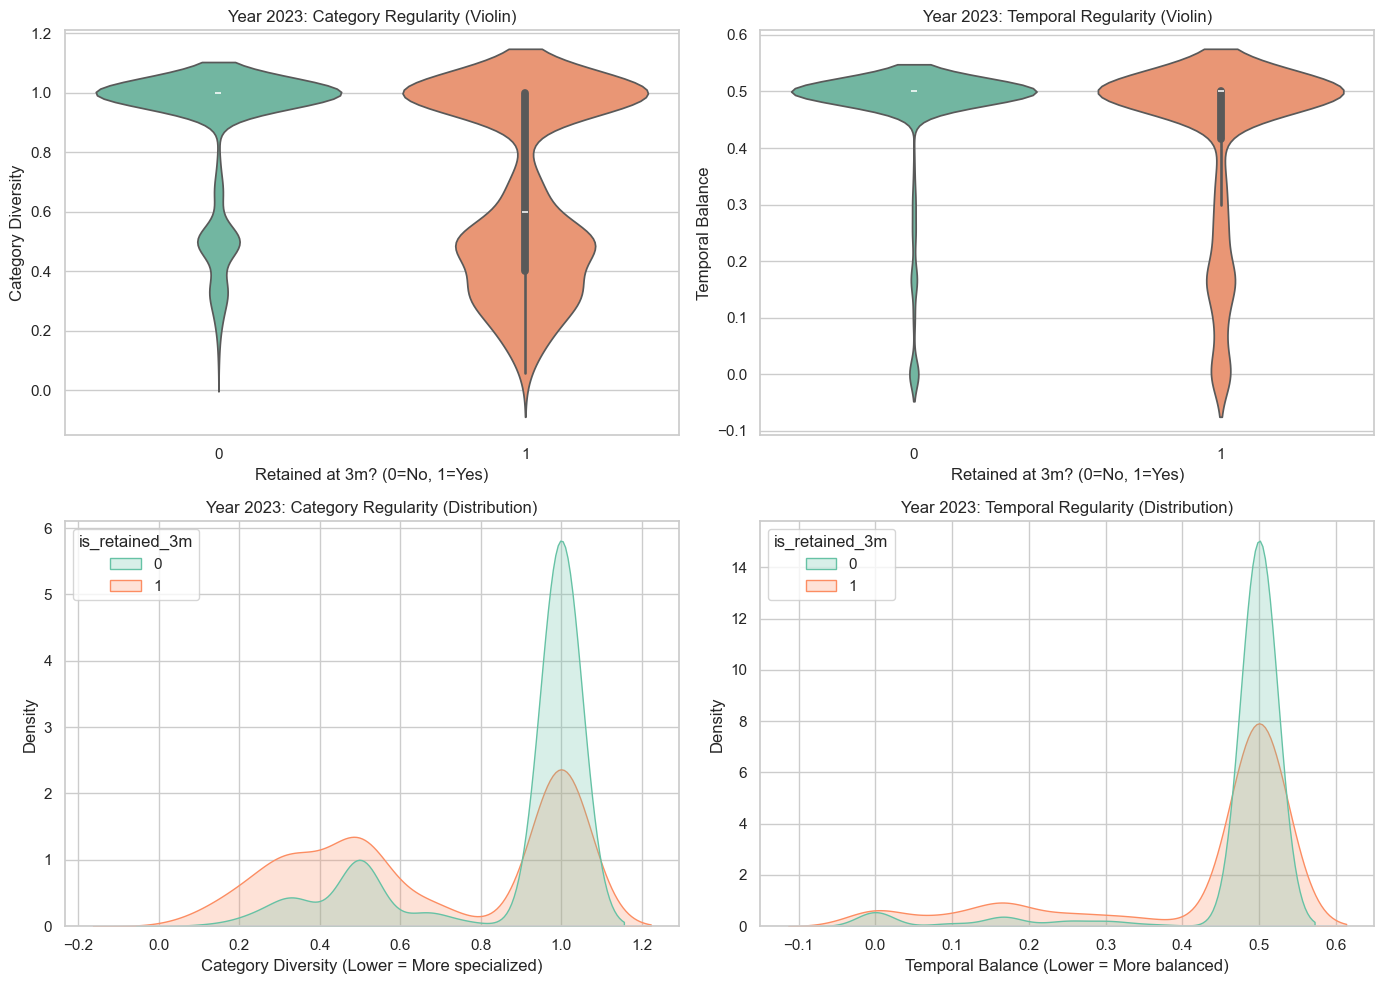

Test on category regularity (diversity) :
P-value = 0.00000
Test on temporal regularity :
P-value = 0.00000
Results saved in h1_exploratory_results_2023.csv

--- Analysis for Year 2024 ---
Total lines : 40071
Total users : 3347
Period : from 2024-01-01 06:00:00 to 2024-12-31 19:30:00


C:\Users\gaspa\AppData\Local\Temp\ipykernel_2472\1260364760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_df['date'] = yearly_df['start_time']


Analyzable users (>90 days seniority) : 2935
New regularity metrics calculated.


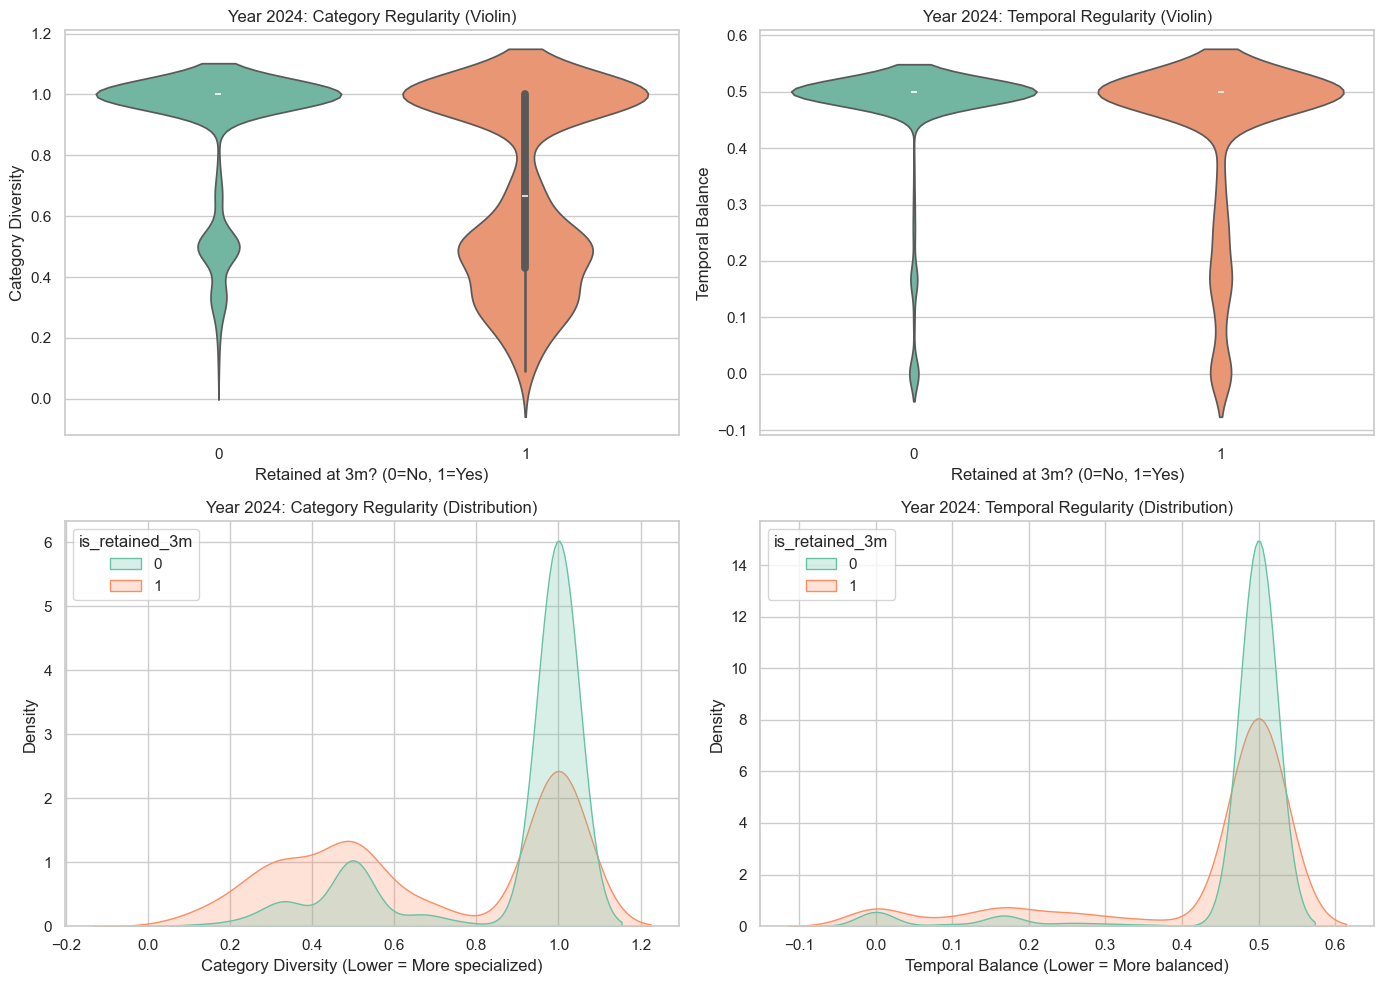

Test on category regularity (diversity) :
P-value = 0.00000
Test on temporal regularity :
P-value = 0.00000
Results saved in h1_exploratory_results_2024.csv

--- Analysis for Year 2025 ---
Total lines : 6726
Total users : 1143
Period : from 2025-01-01 05:30:00 to 2025-03-22 10:00:00
Analyzable users (>90 days seniority) : 0
New regularity metrics calculated.
Not enough data for category regularity test.
Not enough data for temporal regularity test.


C:\Users\gaspa\AppData\Local\Temp\ipykernel_2472\1260364760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_df['date'] = yearly_df['start_time']


In [19]:
def analyze_year(year):
    print(f"\n--- Analysis for Year {year} ---")
    yearly_df = unified_df[unified_df['start_time'].dt.year == year]
    yearly_df['date'] = yearly_df['start_time']
    yearly_df = yearly_df.sort_values(['user_id', 'date'])

    print(f"Total lines : {len(yearly_df)}")
    print(f"Total users : {yearly_df['user_id'].nunique()}")
    print(f"Period : from {yearly_df['date'].min()} to {yearly_df['date'].max()}")

    # Feature Engineering
    user_start = yearly_df.groupby('user_id')['date'].min().reset_index()
    user_start.columns = ['user_id', 'start_date']
    df = yearly_df.merge(user_start, on='user_id')

    df['days_since_start'] = (df['date'] - df['start_date']).dt.days

    max_date = df['date'].max()
    cutoff_date = max_date - timedelta(days=90)
    valid_users = user_start[user_start['start_date'] <= cutoff_date]['user_id']
    df_cohort = df[df['user_id'].isin(valid_users)].copy()

    print(f"Analyzable users (>90 days seniority) : {df_cohort['user_id'].nunique()}")

    early_activity = df_cohort[df_cohort['days_since_start'] <= 14]

    h1_data = early_activity.groupby('user_id').size().reset_index(name='frequency_14d')

    active_after_90d = df_cohort[df_cohort['days_since_start'] > 90]['user_id'].unique()
    h1_data['is_retained_3m'] = h1_data['user_id'].isin(active_after_90d).astype(int)

    # Regularity Metrics
    def calculate_category_diversity(x):
        if len(x) == 0:
            return np.nan
        unique_cats = x.nunique()
        total_sessions = len(x)
        return unique_cats / total_sessions

    category_reg = early_activity.groupby('user_id')['category_name'].agg(calculate_category_diversity).reset_index(name='category_regularity_14d')

    def calculate_temporal_balance(x):
        if len(x) == 0:
            return np.nan
        weekday_count = x.dt.weekday.lt(5).sum()
        total = len(x)
        if total == 0:
            return np.nan
        weekday_prop = weekday_count / total
        return abs(weekday_prop - 0.5)

    temporal_reg = early_activity.groupby('user_id')['date'].agg(calculate_temporal_balance).reset_index(name='temporal_regularity_14d')

    h1_data = h1_data.merge(category_reg, on='user_id', how='left')
    h1_data = h1_data.merge(temporal_reg, on='user_id', how='left')

    print("New regularity metrics calculated.")
    if not h1_data.empty:
        # Visualizations (Violin and KDE)
        plt.figure(figsize=(14, 10))

        # Violin Plot Category Regularity
        plt.subplot(2, 2, 1)
        sns.violinplot(x='is_retained_3m', y='category_regularity_14d', data=h1_data, palette="Set2", hue='is_retained_3m', legend=False)
        plt.title(f"Year {year}: Category Regularity (Violin)")
        plt.xlabel("Retained at 3m? (0=No, 1=Yes)")
        plt.ylabel("Category Diversity")

        # Violin Plot Temporal Regularity
        plt.subplot(2, 2, 2)
        sns.violinplot(x='is_retained_3m', y='temporal_regularity_14d', data=h1_data, palette="Set2", hue='is_retained_3m', legend=False)
        plt.title(f"Year {year}: Temporal Regularity (Violin)")
        plt.xlabel("Retained at 3m? (0=No, 1=Yes)")
        plt.ylabel("Temporal Balance")

        # KDE Plot Category Distribution
        plt.subplot(2, 2, 3)
        sns.kdeplot(data=h1_data, x='category_regularity_14d', hue='is_retained_3m', fill=True, palette="Set2", common_norm=False)
        plt.title(f"Year {year}: Category Regularity (Distribution)")
        plt.xlabel("Category Diversity (Lower = More specialized)")
        plt.ylabel("Density")

        # KDE Plot Temporal Distribution
        plt.subplot(2, 2, 4)
        sns.kdeplot(data=h1_data, x='temporal_regularity_14d', hue='is_retained_3m', fill=True, palette="Set2", common_norm=False)
        plt.title(f"Year {year}: Temporal Regularity (Distribution)")
        plt.xlabel("Temporal Balance (Lower = More balanced)")
        plt.ylabel("Density")

        plt.tight_layout()
        plt.show()

    # Statistical Analysis
    valid_cat = h1_data.dropna(subset=['category_regularity_14d'])
    if not valid_cat.empty and valid_cat['is_retained_3m'].nunique() > 1:
        group_retained_cat = valid_cat[valid_cat['is_retained_3m'] == 1]['category_regularity_14d']
        group_churned_cat = valid_cat[valid_cat['is_retained_3m'] == 0]['category_regularity_14d']
        from scipy.stats import mannwhitneyu
        stat, p_value_cat = mannwhitneyu(group_retained_cat, group_churned_cat, alternative='two-sided')
        print("Test on category regularity (diversity) :")
        print(f"P-value = {p_value_cat:.5f}")
    else:
        print("Not enough data for category regularity test.")

    valid_temp = h1_data.dropna(subset=['temporal_regularity_14d'])
    if not valid_temp.empty and valid_temp['is_retained_3m'].nunique() > 1:
        group_retained_temp = valid_temp[valid_temp['is_retained_3m'] == 1]['temporal_regularity_14d']
        group_churned_temp = valid_temp[valid_temp['is_retained_3m'] == 0]['temporal_regularity_14d']
        from scipy.stats import mannwhitneyu
        stat, p_value_temp = mannwhitneyu(group_retained_temp, group_churned_temp, alternative='two-sided')
        print("Test on temporal regularity :")
        print(f"P-value = {p_value_temp:.5f}")
    else:
        print("Not enough data for temporal regularity test.")

    # Save Results
    if not h1_data.empty:
        h1_data.to_csv(f'h1_exploratory_results_{year}.csv', index=False)
        print(f"Results saved in h1_exploratory_results_{year}.csv")

# Analysis for each year
for year in [2023, 2024, 2025]:
    analyze_year(year)